# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import tensorflow.keras.backend as K
layers = keras.layers
tf.compat.v1.disable_eager_execution()  # gp loss won't work with eager
from functools import partial
from NuRadioReco.utilities import fft
from NuRadioReco.utilities import units
from NuRadioReco.framework import base_trace
import sys

In [2]:
sys.path.insert(1, '/lustre/fs22/group/radio/dhjelm/')
import data_preprocessing

# Data

## Load data from file and shuffle 

In [3]:
dataset = np.load('/lustre/fs22/group/radio/dhjelm/data.npy')
np.random.shuffle(dataset)

## Preprocess data

In [4]:
# RMS
rms = data_preprocessing.rms_preprocessing(dataset)

# L1
l1 = data_preprocessing.l1_preprocessing(rms)

# Remove DC-offset
fft_traces = fft.time2freq(l1, 3.2*units.GHz)
# no_offset = fft_traces[:,1:len(fft_traces[0])]
fft_traces[:,0] = 0
data_no_offset = fft.freq2time(fft_traces, 3.2*units.GHz)

# Shorten the trace
short = data_no_offset[:,0:512]
# short = data_no_offset

# Normalization
normalize = data_preprocessing.normalize(short)

# Set data to the normailzed data
data = normalize

# Calculate trace_length
trace_length = len(data[0])


## Train on FFT data

In [5]:
# data = abs(fft.time2freq(data, 3.2*units.GHz))
# data = data[:,1:len(data[0])]
# trace_length = len(data[0])

## Plot a couple of traces to check that everything looks okey

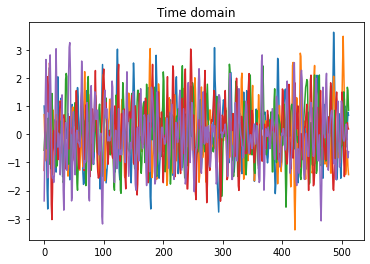

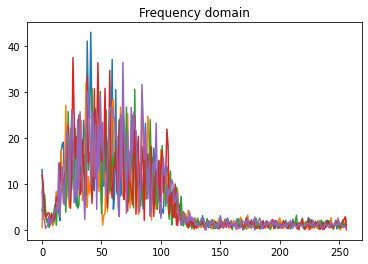

In [6]:
for i in range(5):
    plt.plot(data[i])
plt.title("Time domain")
plt.show()

for i in range(5):
    plt.plot(abs(fft.time2freq(data[i], 3.2*units.GHz)))
plt.title("Frequency domain")
plt.show()


# GAN implementation

In [7]:
# Decide latent size
latent_size = 128

# Calculate trace length
trace_length = len(data[0])

# Calculate number of generator blocks based on the factor between trace_length and latent_size
number_of_blocks = trace_length//(latent_size*2)



## Generator

In [8]:
# Generator architecture
def generator_model(latent_size):
    """ Generator network """
    
    # Arguments used for the layers
    kwargs = {'kernel_size': 9, 'padding': 'same', 'kernel_initializer': 'he_normal'}
    
    noise = layers.Input(shape=(latent_size,1), name = "noise")
    
    x = layers.Dense(latent_size)(noise)
    
    x = layers.Conv1D(filters=latent_size/4, **kwargs)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1DTranspose(filters=latent_size/8, strides=2, **kwargs)(x)
    x = layers.LeakyReLU()(x)
    
    x = layers.Conv1D(filters=latent_size/8, **kwargs)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1DTranspose(filters=latent_size/16, strides=2, **kwargs)(x)
    x = layers.LeakyReLU()(x)
    
#     x = layers.Conv1D(filters=latent_size/16, **kwargs)(x)
#     x = layers.ReLU()(x)
#     x = layers.Conv1DTranspose(filters=latent_size/32, strides=2, **kwargs)(x)
#     x = layers.ReLU()(x)
    
    
    
    x = layers.Conv1D(filters=latent_size/16, **kwargs)(x)
    x = layers.LeakyReLU()(x)
    x = layers.Conv1D(filters=1, **kwargs)(x)
    
    generator = keras.models.Model(noise, x, name="generator")
    return generator

    
    

In [9]:
# Decide latent size
latent_size = 128

# Create the generator
g = generator_model(latent_size)
g.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           [(None, 128, 1)]          0         
_________________________________________________________________
dense (Dense)                (None, 128, 128)          256       
_________________________________________________________________
conv1d (Conv1D)              (None, 128, 32)           36896     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 32)           0         
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 256, 16)           4624      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 256, 16)           23

## Critic (Discriminator)

In [10]:
# Critic architecture
def critic_model(trace_length):
    """ Critic network """
    
    kwargs1 = {'kernel_size':9, 'padding':'same', 'kernel_initializer':'he_normal', 'strides':2}
    kwargs2 = {'kernel_size':9, 'padding':'same', 'kernel_initializer':'he_normal'}
    
    signal_input = layers.Input(shape=(trace_length, 1), name = "signal_input")

    # Each bloch halves the dimension
    
    # Block 1
    x = layers.Conv1D(filters=trace_length//32, **kwargs1)(signal_input)
    x = layers.LeakyReLU()(x)
    x = layers.LayerNormalization()(x)
    x = layers.Conv1D(filters=trace_length//32, **kwargs2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.LayerNormalization()(x)
    
    # Block 2
    x = layers.Conv1D(filters=trace_length//16, **kwargs1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.LayerNormalization()(x)
    x = layers.Conv1D(filters=trace_length//16, **kwargs2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.LayerNormalization()(x)
    
    # Block 3
    x = layers.Conv1D(filters=trace_length//8, **kwargs1)(x)
    x = layers.LeakyReLU()(x)
    x = layers.LayerNormalization()(x)
    x = layers.Conv1D(filters=trace_length//8, **kwargs2)(x)
    x = layers.LeakyReLU()(x)
    x = layers.LayerNormalization()(x)
    
    x = layers.Conv1D(filters=2, **kwargs1)(x)
    x = layers.LeakyReLU()(x)

    x = layers.Flatten()(x)
    
    x = layers.Dense(1)(x)
    

    critic = keras.models.Model(signal_input, x,name="critic")
    
    return critic

In [11]:
# Create the critic
critic = critic_model(trace_length)
critic.summary()

Model: "critic"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
signal_input (InputLayer)    [(None, 512, 1)]          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 256, 16)           160       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 256, 16)           0         
_________________________________________________________________
layer_normalization (LayerNo (None, 256, 16)           32        
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 256, 16)           2320      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 256, 16)           0         
_________________________________________________________________
layer_normalization_1 (Layer (None, 256, 16)           32   

## Training pipelines

Pipelines between the networks to be able to construct and train the GAN

In [12]:
def make_trainable(model, trainable):
    ''' Freezes/unfreezes the weights in the given model '''
    for layer in model.layers:

        if type(layer) is layers.BatchNormalization:
            layer.trainable = True
        else:
            layer.trainable = trainable

In [13]:
# Freeze the critic during the generator training and unfreeze the generator during the generator training
make_trainable(critic, False) 
make_trainable(g, True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
noise (InputLayer)           [(None, 128, 1)]          0         
_________________________________________________________________
generator (Functional)       (None, 512, 1)            45913     
_________________________________________________________________
critic (Functional)          (None, 1)                 73459     
Total params: 119,372
Trainable params: 45,913
Non-trainable params: 73,459
_________________________________________________________________


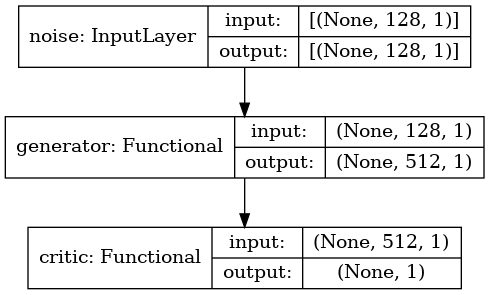

In [14]:
# Stack the generator o top of the critic and finiliaze the training pipeline of the generator
gen_input = g.inputs
generator_training = keras.models.Model(gen_input, critic(g(gen_input)))
generator_training.summary()
keras.utils.plot_model(generator_training, show_shapes=True)

# Wasserstein loss

In [15]:
def wasserstein_loss(y_true, y_pred):
    """Calculates the Wasserstein loss - critic maximises the distance between its output for real and generated samples.
    To achieve this generated samples have the label -1 and real samples the label 1. Multiplying the outputs by the labels results to the wasserstein loss via the Kantorovich-Rubinstein duality"""
    return K.mean(y_true * y_pred)

# Compile generator for training using the Wasserstein loss as loss function
generator_training.compile(keras.optimizers.Adam(
    0.0001, beta_1=0.5, beta_2=0.9, decay=0.0), loss=[wasserstein_loss])


## Gradient penalty

To obtain the Wasserstein distance, we have to use the gradient penalty to enforce the Lipschitz constraint.
Therefore, we need to design a layer that samples on straight lines between reals and fakes samples 

In [16]:
# Size of the batches used in training
BATCH_SIZE = 64

class UniformLineSampler(tf.keras.layers.Layer):
    def __init__(self, batch_size):
        super().__init__()
        self.batch_size = batch_size

    def call(self, inputs, **kwargs):
        weights = K.random_uniform((self.batch_size, 1, 1))
        return(weights * inputs[0]) + ((1 - weights) * inputs[1])

    def compute_output_shape(self, input_shape):
        return input_shape[0]

In [17]:
make_trainable(critic, True)  # unfreeze the critic during the critic training
make_trainable(g, False)  # freeze the generator during the critic training

g_out = g(g.inputs)
critic_out_fake_samples = critic(g_out)
critic_out_data_samples = critic(critic.inputs)
averaged_batch = UniformLineSampler(BATCH_SIZE)([g_out, critic.inputs[0]])
averaged_batch_out = critic(averaged_batch)
critic_training = keras.models.Model(inputs=[g.inputs, critic.inputs], outputs=[critic_out_fake_samples, critic_out_data_samples, averaged_batch_out])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
noise (InputLayer)              [(None, 128, 1)]     0                                            
__________________________________________________________________________________________________
generator (Functional)          (None, 512, 1)       45913       noise[0][0]                      
__________________________________________________________________________________________________
signal_input (InputLayer)       [(None, 512, 1)]     0                                            
__________________________________________________________________________________________________
uniform_line_sampler (UniformLi (64, 512, 1)         0           generator[1][0]                  
                                                                 signal_input[0][0]         

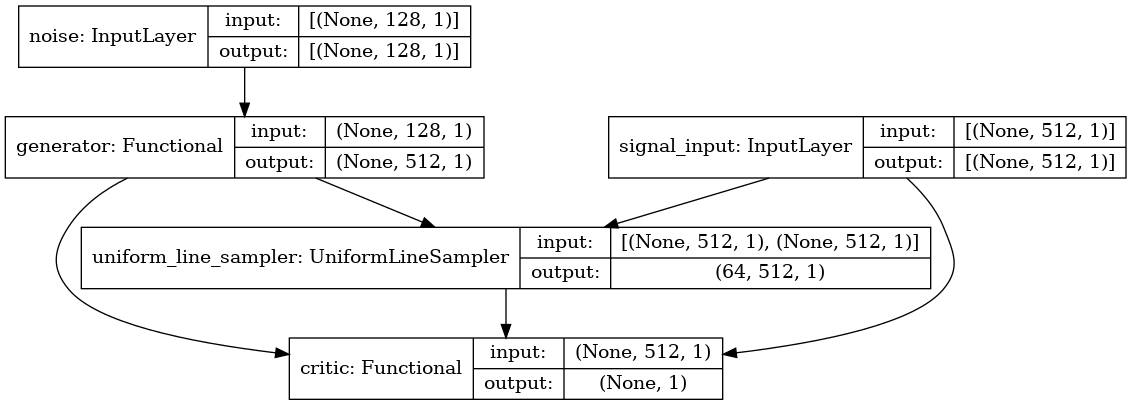

In [18]:
critic_training.summary()
keras.utils.plot_model(critic_training, show_shapes=True)

### Gradient penalty loss

In [19]:
def gradient_penalty_loss(y_true, y_pred, averaged_batch, penalty_weight):
    """Calculates the gradient penalty.
    The 1-Lipschitz constraint of improved WGANs is enforced by adding a term that penalizes a gradient norm in the critic unequal to 1."""
    
    # Gradients
    gradients = K.gradients(y_pred, averaged_batch)[0]
    
    # Gradients sqruared
    gradients_sqr = K.square(gradients)
    
    # Sum over the rows
    gradients_sqr_sum = K.sum(gradients_sqr, axis=np.arange(1, len(gradients_sqr.shape)))
    
    # Sqrt
    gradient_l2_norm =  K.sqrt(gradients_sqr_sum) 
                              
    # Compute penalty_weight * (1 - ||grad||)^2 still for each single sample                        
    gradient_penalty = penalty_weight * K.square(1 - gradient_l2_norm)
    
    return K.mean(gradient_penalty)

# Construct the gradient penalty
gradient_penalty_weight = 5
gradient_penalty = partial(gradient_penalty_loss, averaged_batch=averaged_batch, penalty_weight=gradient_penalty_weight)  
gradient_penalty.__name__ = 'gradient_penalty'

In [20]:
# Compile critic
critic_training.compile(keras.optimizers.Adam(0.00005, beta_1=0.5, beta_2=0.9, decay=0.0), loss=[wasserstein_loss, wasserstein_loss, gradient_penalty])

In [21]:
# Keras throws an error when calculating a loss without having a label -> needed for using the gradient penalty loss
positive_y = np.ones(BATCH_SIZE)
negative_y = -positive_y
dummy = np.zeros(BATCH_SIZE) 


# Training

In [22]:
# Create arrays for generator and critic loss
generator_loss = []
critic_loss = []

In [23]:
# Training parameters
EPOCHS = 100
nsamples = len(data)
critic_iterations = 5
iterations_per_epoch = nsamples*2//(BATCH_SIZE*critic_iterations)
iters = 0
print(iterations_per_epoch)

65


Epoch:  0


2022-09-15 07:46:19.418808: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-15 07:46:19.494247: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2022-09-15 07:46:19.524706: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Iteration 1
Critic loss: [568.7918, -0.09159699, 0.092959926, 568.79047]
Generator loss: 0.018160552


/afs/ifh.de/group/radio/software/anaconda_p3/envs/jupyter/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


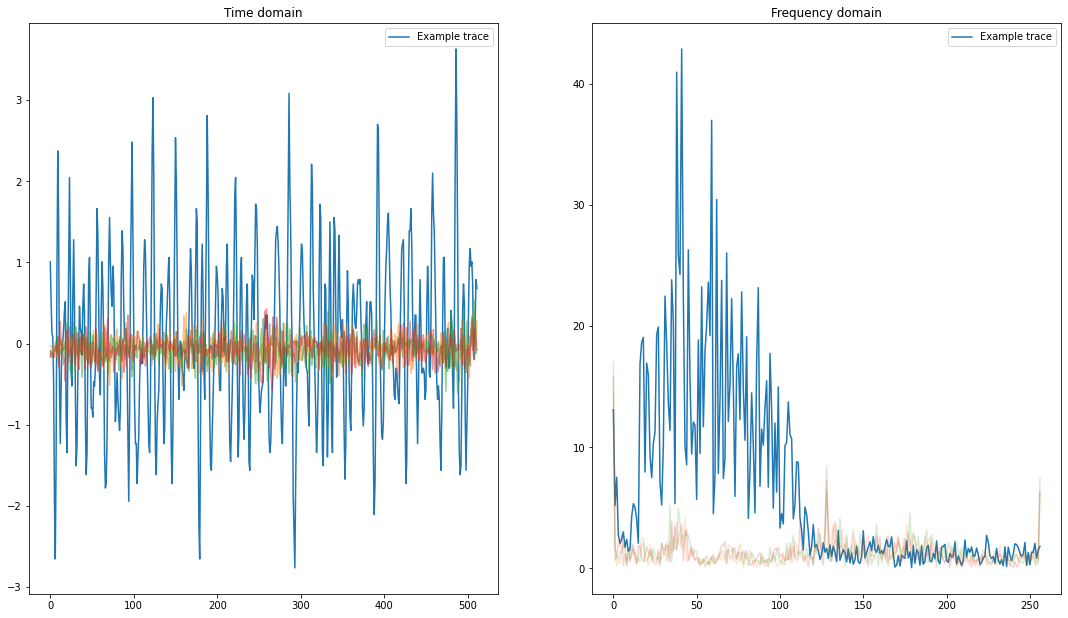

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Iteration 301
Critic loss: [-5.8409867, -1.2543722, -5.8175755, 1.2309607]
Generator loss: 1.2865367


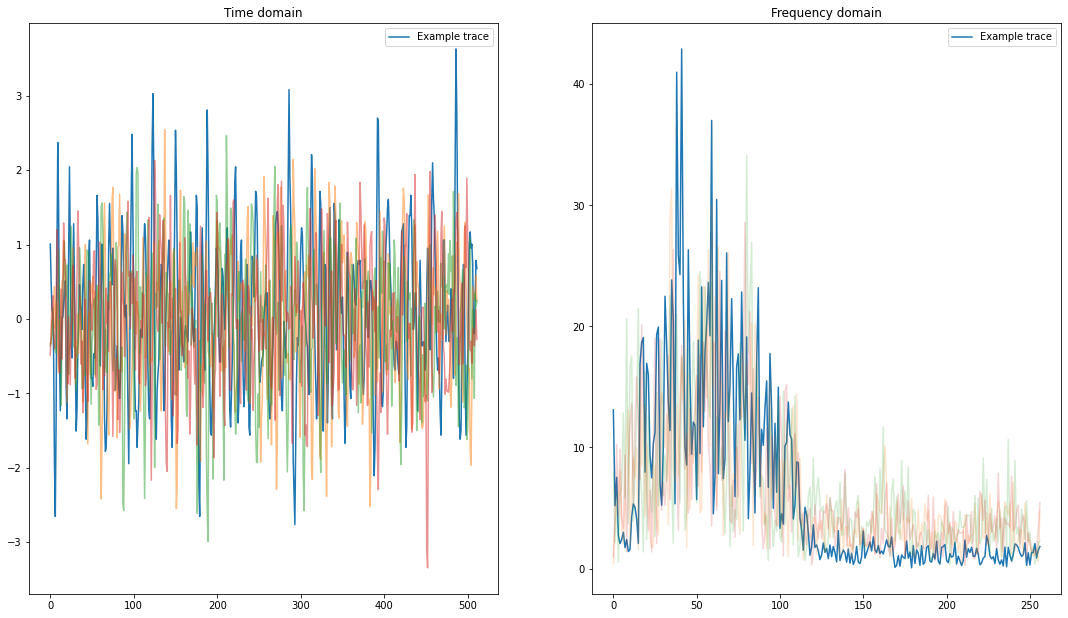

Epoch:  5
Epoch:  6
Epoch:  7
Epoch:  8
Epoch:  9
Iteration 601
Critic loss: [-2.6707635, -2.1830313, -1.0969009, 0.60916865]
Generator loss: 2.6059198


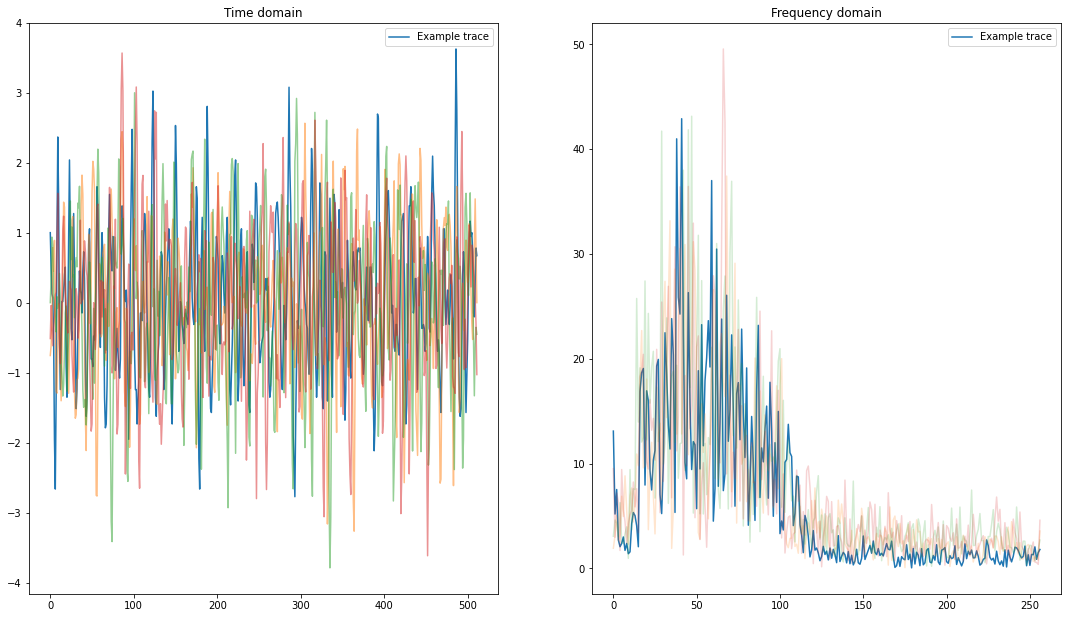

Epoch:  10
Epoch:  11
Epoch:  12
Epoch:  13
Iteration 901
Critic loss: [-2.044767, -0.16703317, -2.1630597, 0.28532606]
Generator loss: 0.2238754


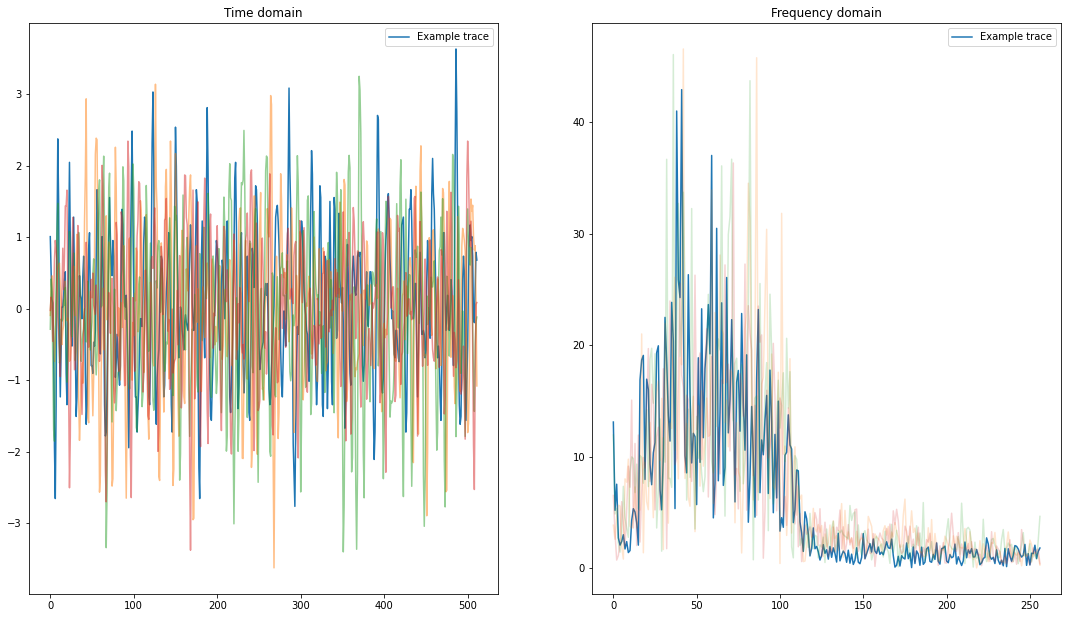

Epoch:  14
Epoch:  15
Epoch:  16
Epoch:  17
Epoch:  18
Iteration 1201
Critic loss: [-1.7022943, 4.901202, -6.8682537, 0.26475734]
Generator loss: -3.796124


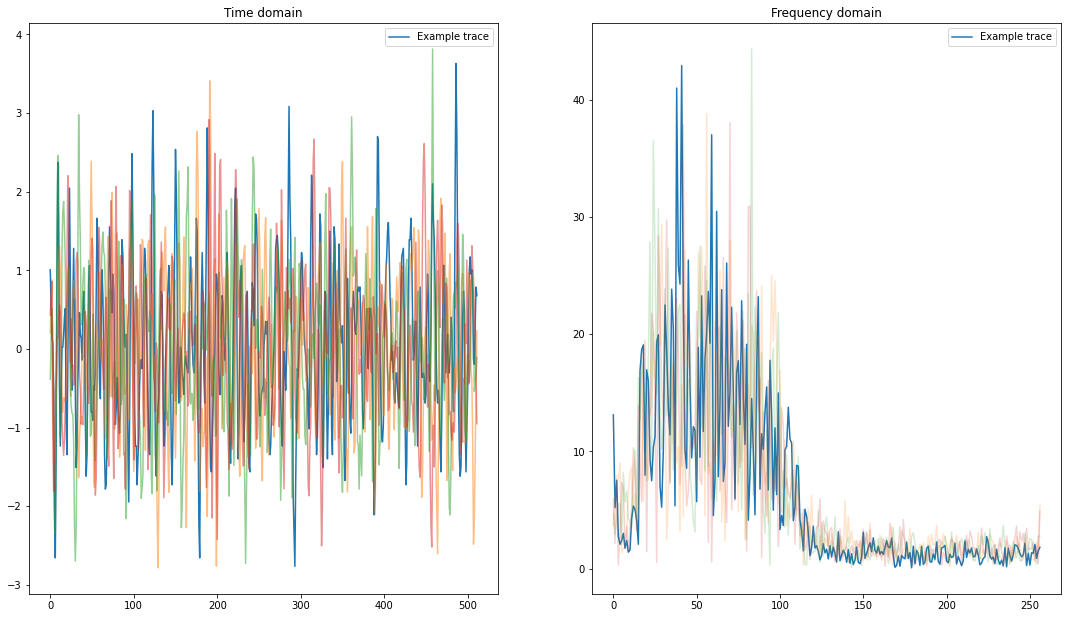

Epoch:  19
Epoch:  20
Epoch:  21
Epoch:  22
Epoch:  23
Iteration 1501
Critic loss: [-2.1085472, -1.216619, -1.2312683, 0.3393402]
Generator loss: 0.6595601


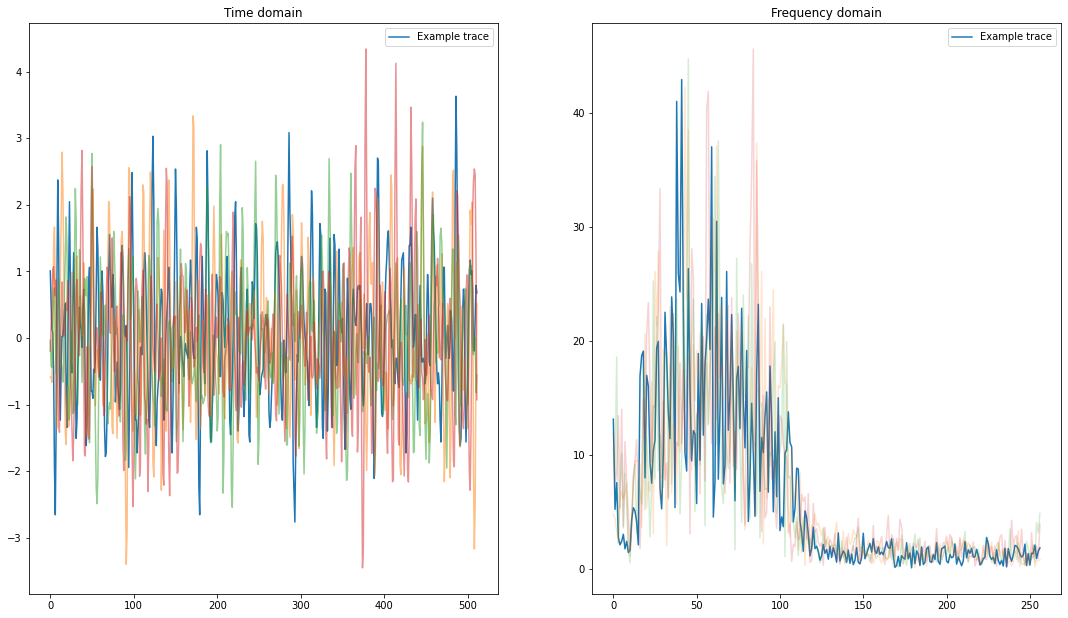

Epoch:  24
Epoch:  25
Epoch:  26
Epoch:  27
Iteration 1801
Critic loss: [-1.7335281, 8.535859, -10.507399, 0.23801121]
Generator loss: -8.292464


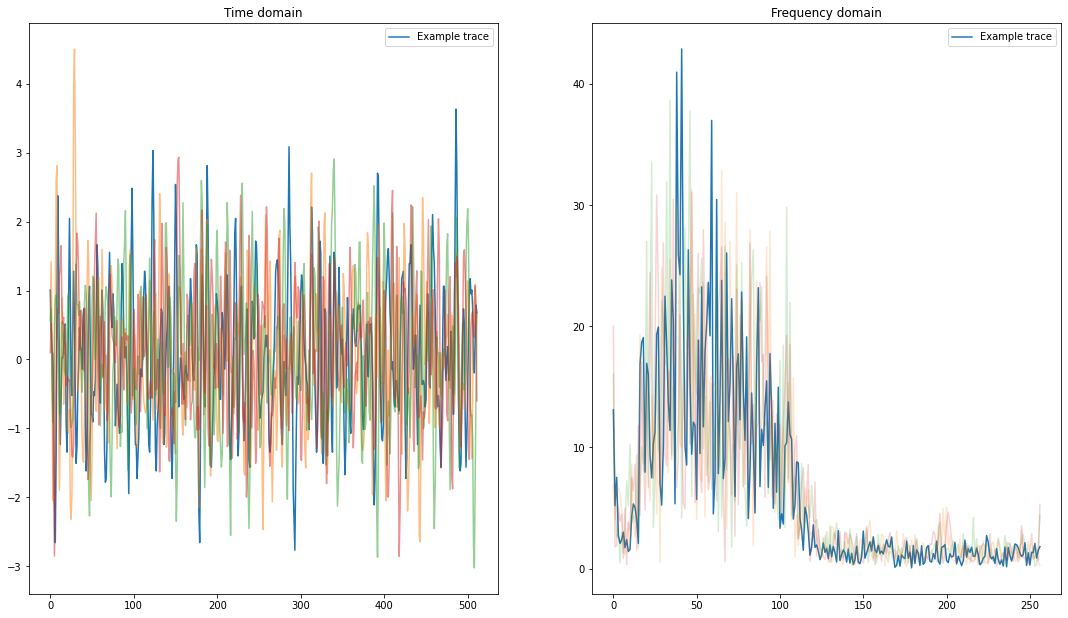

Epoch:  28
Epoch:  29
Epoch:  30
Epoch:  31
Epoch:  32
Iteration 2101
Critic loss: [-1.3607386, 1.4404231, -3.0293417, 0.22817987]
Generator loss: -2.3456242


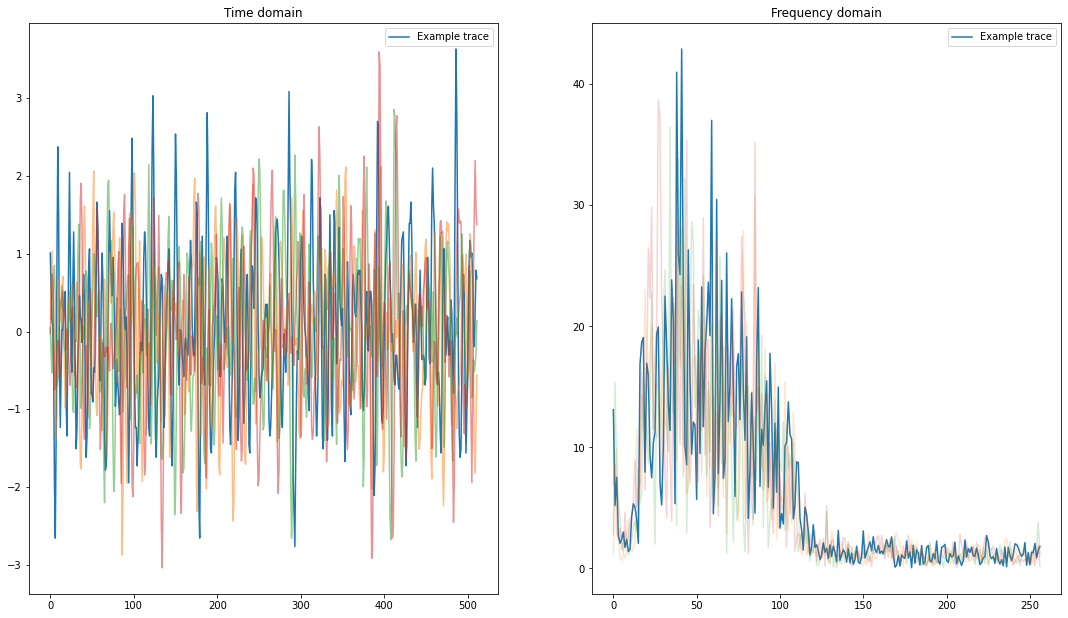

Epoch:  33
Epoch:  34
Epoch:  35
Epoch:  36
Iteration 2401
Critic loss: [-1.4173536, 6.2940626, -7.8397346, 0.12831813]
Generator loss: -5.7264194


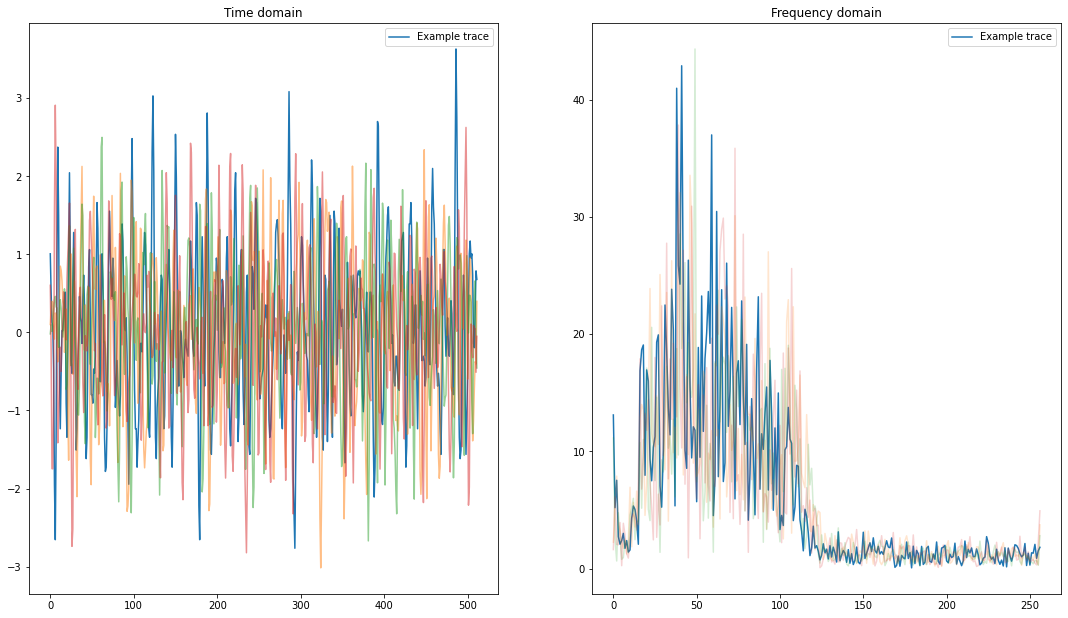

Epoch:  37
Epoch:  38
Epoch:  39
Epoch:  40
Epoch:  41
Iteration 2701
Critic loss: [-2.163432, -5.956464, 3.6037238, 0.1893082]
Generator loss: 5.396334


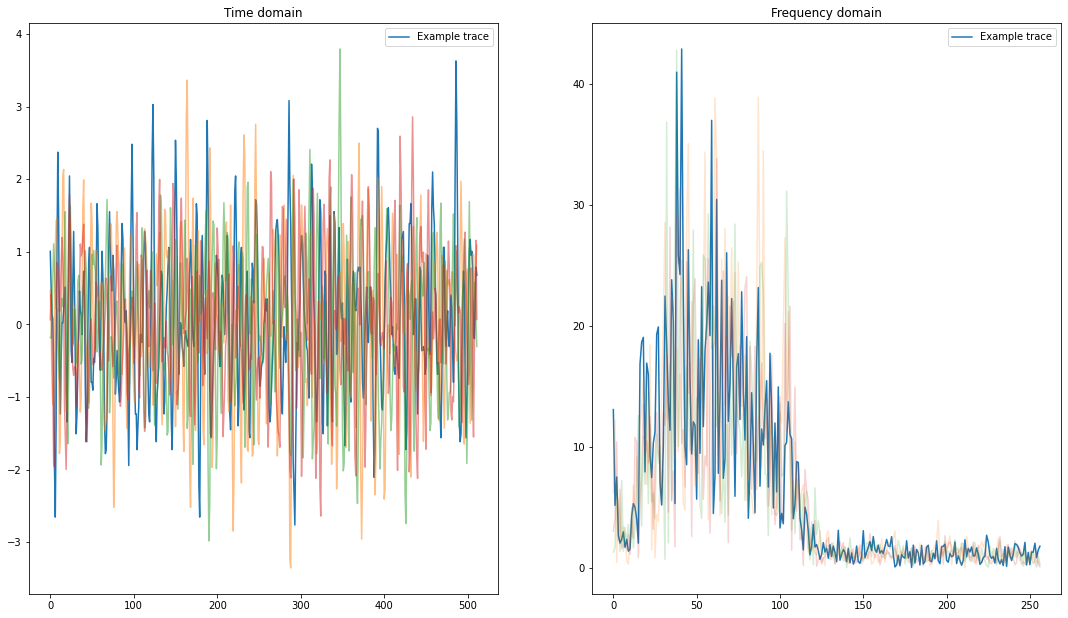

Epoch:  42
Epoch:  43
Epoch:  44
Epoch:  45
Epoch:  46
Iteration 3001
Critic loss: [-1.2470522, 0.7463323, -2.1908078, 0.19742334]
Generator loss: -0.75442415


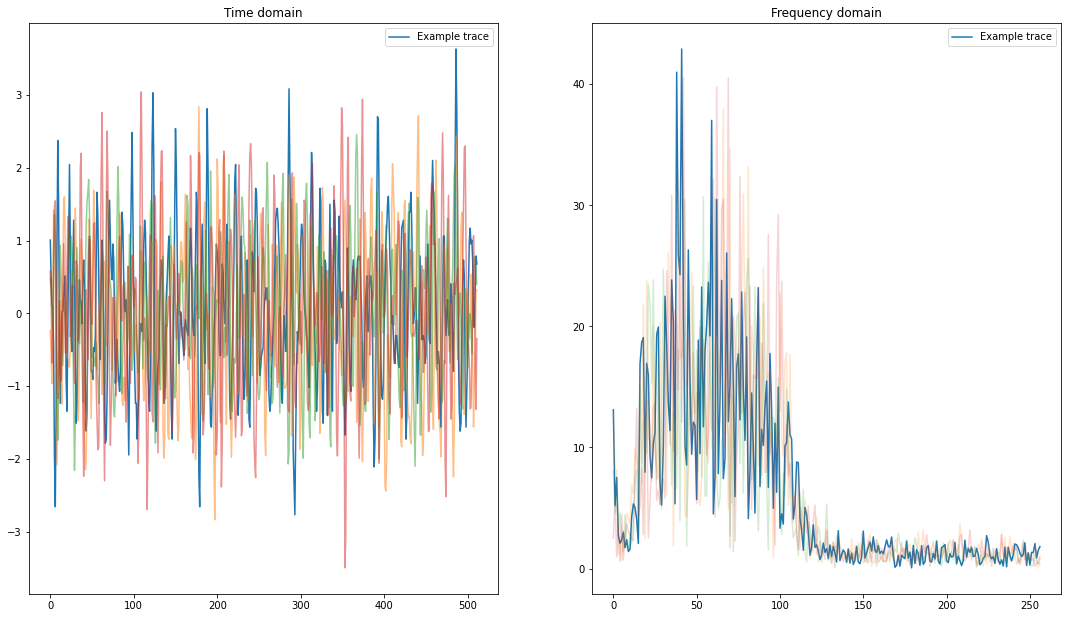

Epoch:  47
Epoch:  48
Epoch:  49
Epoch:  50
Iteration 3301
Critic loss: [-1.7522418, 3.1529362, -5.385459, 0.48028105]
Generator loss: -2.4593968


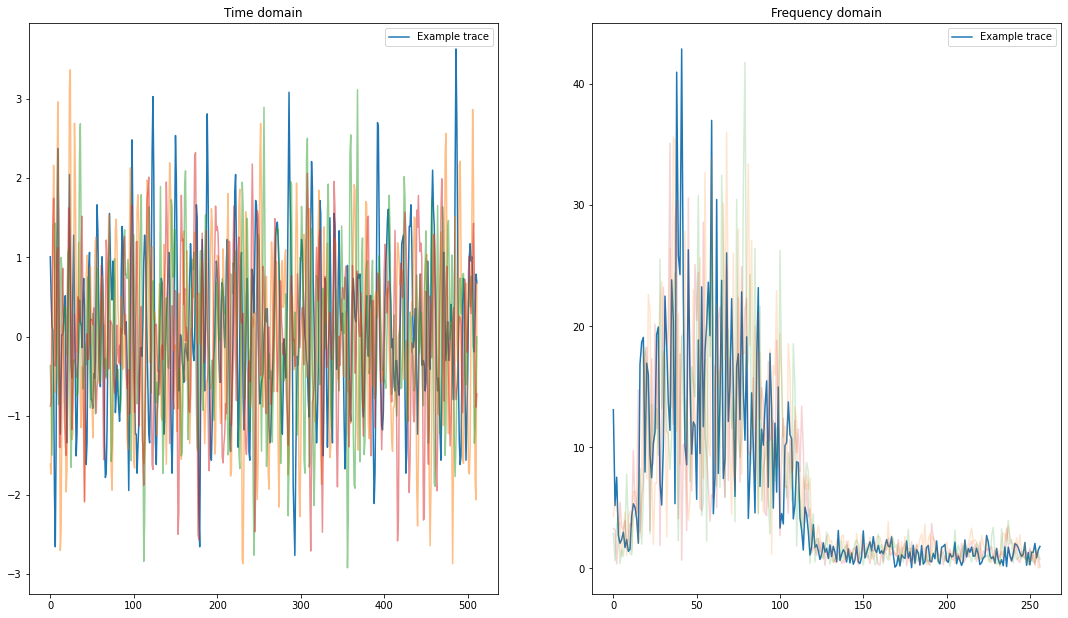

Epoch:  51
Epoch:  52
Epoch:  53
Epoch:  54
Epoch:  55
Iteration 3601
Critic loss: [-1.7614465, -0.6562669, -1.400029, 0.29484943]
Generator loss: 0.037325677


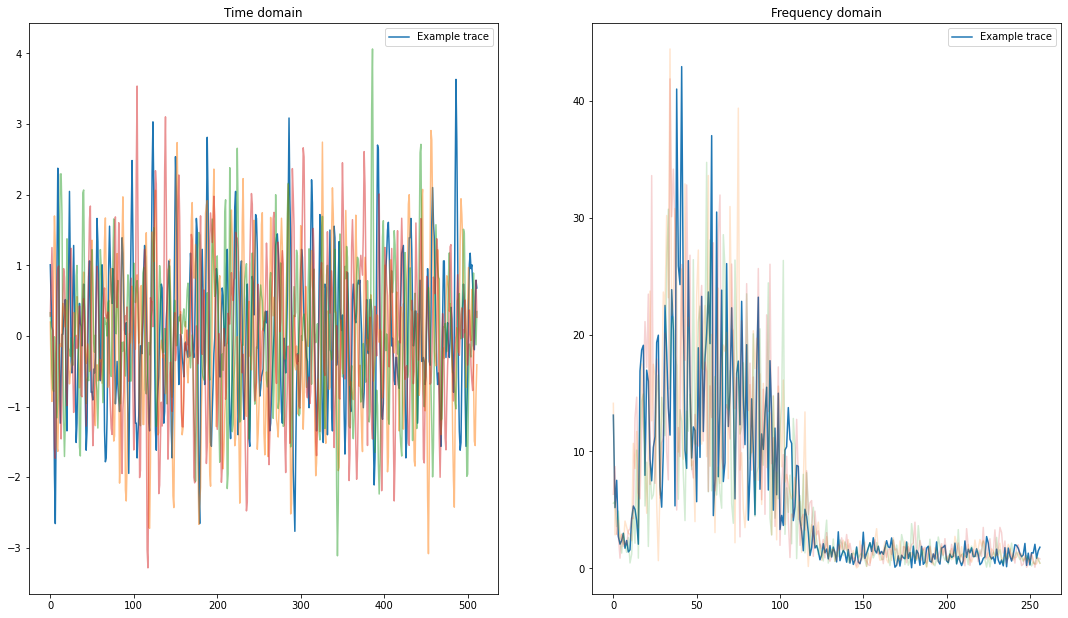

Epoch:  56
Epoch:  57
Epoch:  58
Epoch:  59
Epoch:  60
Iteration 3901
Critic loss: [-1.5173168, -0.91761816, -0.78935885, 0.18966019]
Generator loss: 1.7864599


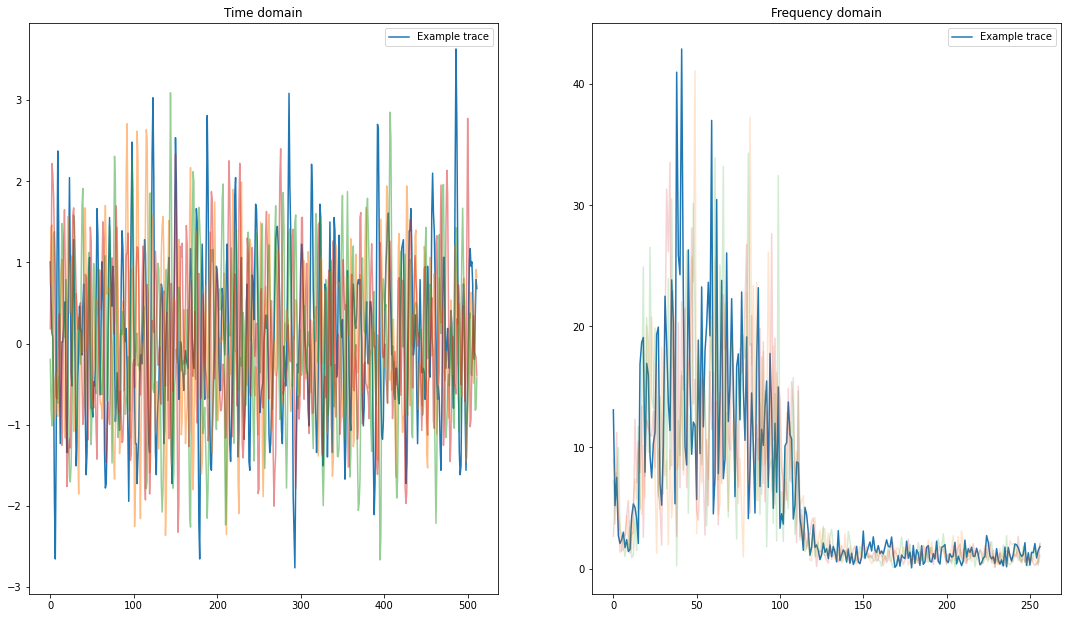

Epoch:  61


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/afs/ifh.de/group/radio/software/anaconda_p3/envs/jupyter/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_20079/1409729523.py", line 23, in <cell line: 1>
    critic_loss.append(critic_training.train_on_batch([noise_batch, bunch], [negative_y, positive_y, dummy]))
  File "/afs/ifh.de/group/radio/software/anaconda_p3/envs/jupyter/lib/python3.9/site-packages/tensorflow/python/keras/engine/training_v1.py", line 1088, in train_on_batch
    outputs = self.train_function(ins)  # pylint: disable=not-callable
  File "/afs/ifh.de/group/radio/software/anaconda_p3/envs/jupyter/lib/python3.9/site-packages/tensorflow/python/keras/backend.py", line 3956, in __call__
    fetched = self._callable_fn(*array_vals,
  File "/afs/ifh.de/group/radio/software/anaconda_p3/envs/jupyter/lib/python3.9/site-packages/tensorflow/python/client/session.py", line

TypeError: object of type 'NoneType' has no len()

In [24]:

for epoch in range(EPOCHS):
    
    print("Epoch: ", epoch)

    for iteration in range(iterations_per_epoch):
#         print(iteration)
       
        for j in range(critic_iterations):
            
            # Pick data in batches 
            bunch=data[BATCH_SIZE*(j+iteration):BATCH_SIZE*(j++iteration+1)]
            bunch = np.expand_dims(bunch, axis=-1)  

            # Generate noise
            noise_batch = np.random.randn(BATCH_SIZE, latent_size)
            noise_batch = np.expand_dims(noise_batch, axis=-1) 
            
#             print(f"Data batch: {np.shape(bunch)}")
#             print(f"Noise batch: {np.shape(noise_batch)}")
       
            
            # Train critic
            critic_loss.append(critic_training.train_on_batch([noise_batch, bunch], [negative_y, positive_y, dummy]))
        

        # Generate noise batch for generator
        noise_batch = np.random.randn(BATCH_SIZE, latent_size)
        noise_batch = np.expand_dims(noise_batch, axis=-1) 
        
        # Train the generator
        generator_loss.append(generator_training.train_on_batch([noise_batch], [positive_y]))  
        iters+=1
        
        # Printing errors and plotting example traces
        if iters % 300 == 1:
            print("Iteration", iters)
            print("Critic loss:", critic_loss[-1])
            print("Generator loss:", generator_loss[-1])
            
            # Generate signals
            noise = np.random.randn(BATCH_SIZE, latent_size)
            noise = np.expand_dims(noise, axis=-1) 
            generated_signals = g.predict_on_batch(noise)
            generated_signals = generated_signals[:,:,0]
#             print(np.shape(generated_signals[0]))
#             print(len(abs(fft.time2freq(generated_signals[0], 3.2*units.GHz))))
            
            
            # Plot data
            
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(18.5, 10.5, forward=True)
            ax1.title.set_text('Time domain')
            ax2.title.set_text('Frequency domain')
            
            

            ax1.plot(data[0], label = "Example trace")
#             plt.plot(np.random.randn(trace_length), label = 'Random noise')
            for i in range(3):
                ax1.plot(generated_signals[i], alpha=0.5)
            
            
            # Plot frequency
            ax2.plot(abs(fft.time2freq(data[0], 3.2*units.GHz)), label = "Example trace")
            for i in range(3):
                ax2.plot(abs(fft.time2freq(generated_signals[i], 3.2*units.GHz)),alpha=0.2)
                
            ax1.legend()
            ax2.legend()
            plt.show()



        
       

        #generated_signal = g.predict_on_batch(np.random.randn(BATCH_SIZE, latent_size))
    
    #print("Critic loss:", critic_loss[-1])
    #print("Generator loss:", generator_loss[-1])


## Loss functions

Text(0, 0.5, 'Loss')

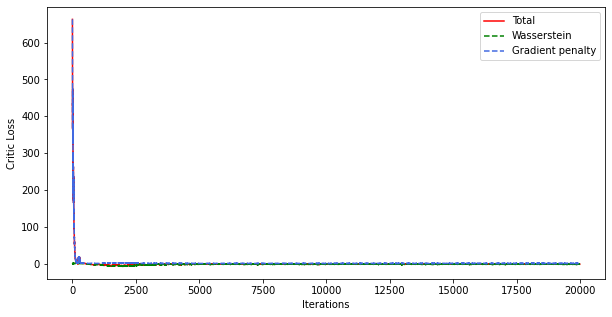

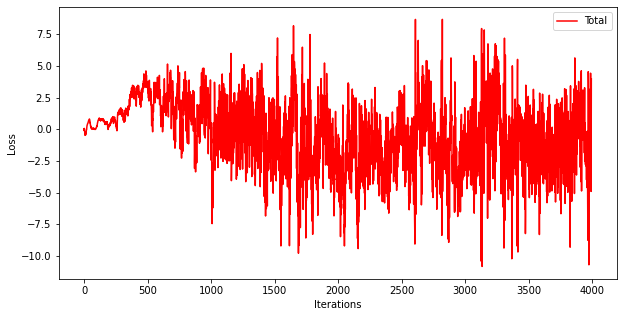

In [25]:
critic_loss = np.array(critic_loss)
plt.subplots(1, figsize=(10, 5))
plt.plot(np.arange(len(critic_loss)), critic_loss[:,0], color='red', markersize=12, label=r'Total')
plt.plot(np.arange(len(critic_loss)), critic_loss[:,1] + critic_loss[:, 2], color='green', label=r'Wasserstein', linestyle='dashed')
plt.plot(np.arange(len(critic_loss)), critic_loss[:, 3], color='royalblue', markersize=12, label=r'Gradient penalty', linestyle='dashed')
plt.legend(loc='upper right')
plt.xlabel(r'Iterations')
plt.ylabel(r'Critic Loss')
#plt.ylim(-6, 3)

generator_loss = np.array(generator_loss)

plt.subplots(1, figsize=(10, 5))
plt.plot(np.arange(len(generator_loss)), generator_loss, color='red', markersize=12, label=r'Total')
plt.legend(loc='upper right')
plt.xlabel(r'Iterations')
plt.ylabel(r'Loss')


# #save the generated networks
# g.save('generator')
# critic.save('critic')

# Analyzing the results

In [40]:
noise = np.random.randn(len(data), latent_size)
noise = np.expand_dims(noise, axis=-1) 
generated_signals = g.predict_on_batch(noise)
generated_signals = generated_signals[:,:,0]

In [41]:
import analyze

In [42]:
analyze.metrics(data, generated_signals)

Mean generated: 0.012719926424324512
Mean data: -4.719829786801699e-18

Std generated: 1.0066492557525635
Std data: 0.9999999999999997



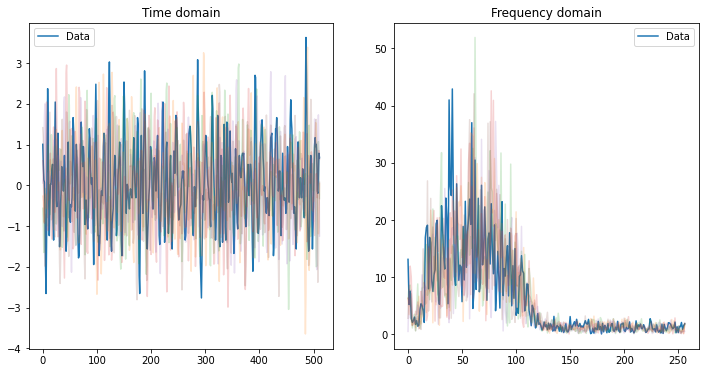

In [43]:
analyze.plot_traces(data, generated_signals, 5)

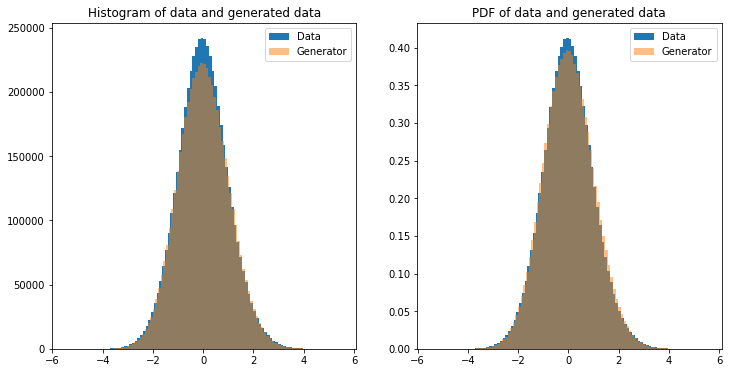

In [44]:
analyze.plot_histograms_time(data, generated_signals)

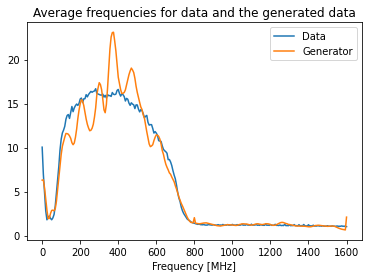

In [45]:
analyze.avg_frequencies(data, generated_signals)

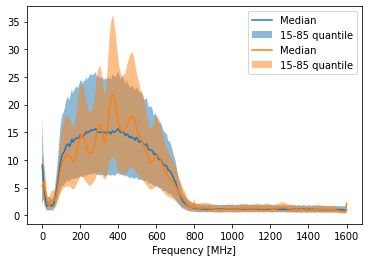

In [46]:
analyze.quantile_frequencies(data, generated_signals)

## Frequency domain

In [55]:
f"data_{len(data[0])}_preprocessed"

'data_512_preprocessed'